Testing model architecture...
Model Architecture Test:
Input shape: torch.Size([1, 1, 32, 32])
Output shape: torch.Size([1, 33])
Feature maps available: ['c1', 's2', 'c3', 's4']
C1 shape: torch.Size([1, 6, 28, 28])
S2 shape: torch.Size([1, 6, 14, 14])
C3 shape: torch.Size([1, 16, 10, 10])
S4 shape: torch.Size([1, 16, 5, 5])

Model Summary:
LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (s4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=33, bias=True)
  (activation): Tanh()
)

Total parameters: 63,661
Trainable parameters: 63,661

Starting training on AMHCD_64 dataset...
Using device: cpu
Found 33 classes: ['ya', 'yab', 'yach', 'yad', 'yadd', 'yae', 'yaf', 'yag', 'yagh', 'yagw', 'yah', 'yahh'

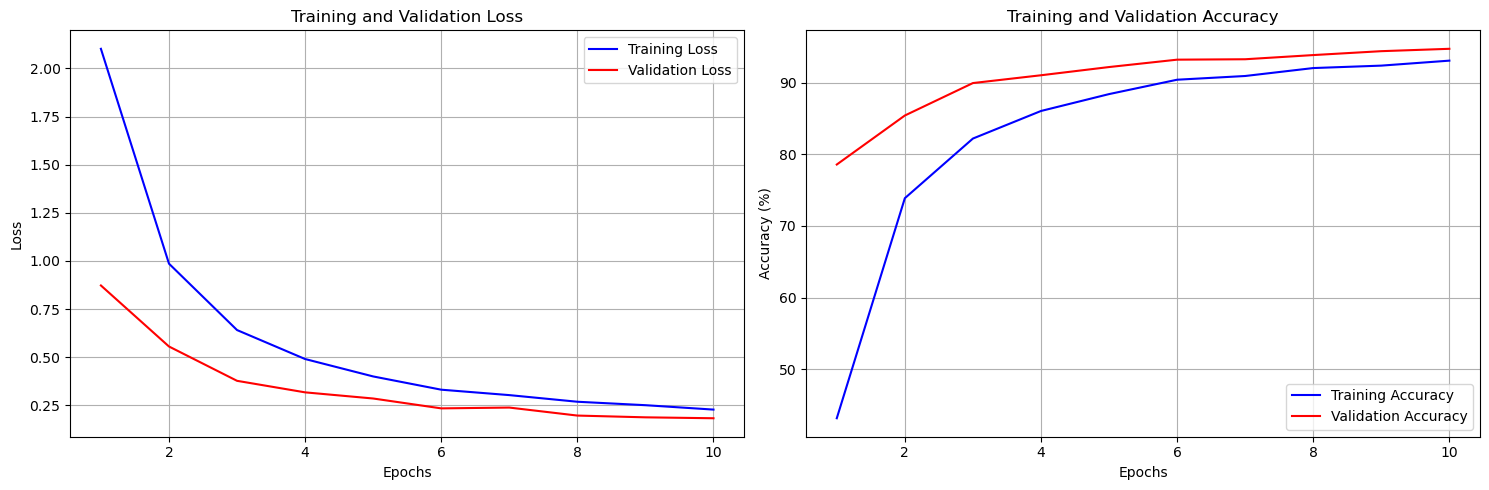

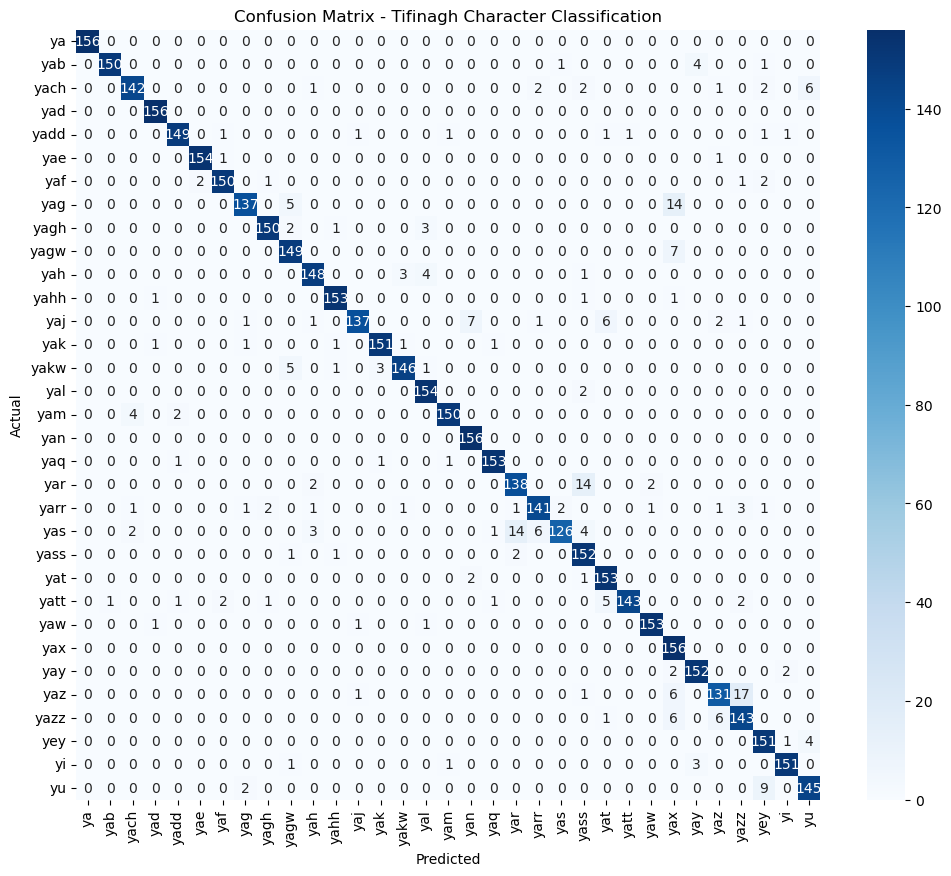


Classification Report:
              precision    recall  f1-score   support

          ya       1.00      1.00      1.00       156
         yab       0.99      0.96      0.98       156
        yach       0.95      0.91      0.93       156
         yad       0.98      1.00      0.99       156
        yadd       0.97      0.96      0.96       156
         yae       0.99      0.99      0.99       156
         yaf       0.97      0.96      0.97       156
         yag       0.96      0.88      0.92       156
        yagh       0.97      0.96      0.97       156
        yagw       0.91      0.96      0.93       156
         yah       0.95      0.95      0.95       156
        yahh       0.97      0.98      0.98       156
         yaj       0.98      0.88      0.93       156
         yak       0.97      0.97      0.97       156
        yakw       0.97      0.94      0.95       156
         yal       0.94      0.99      0.97       156
         yam       0.98      0.96      0.97       156
   

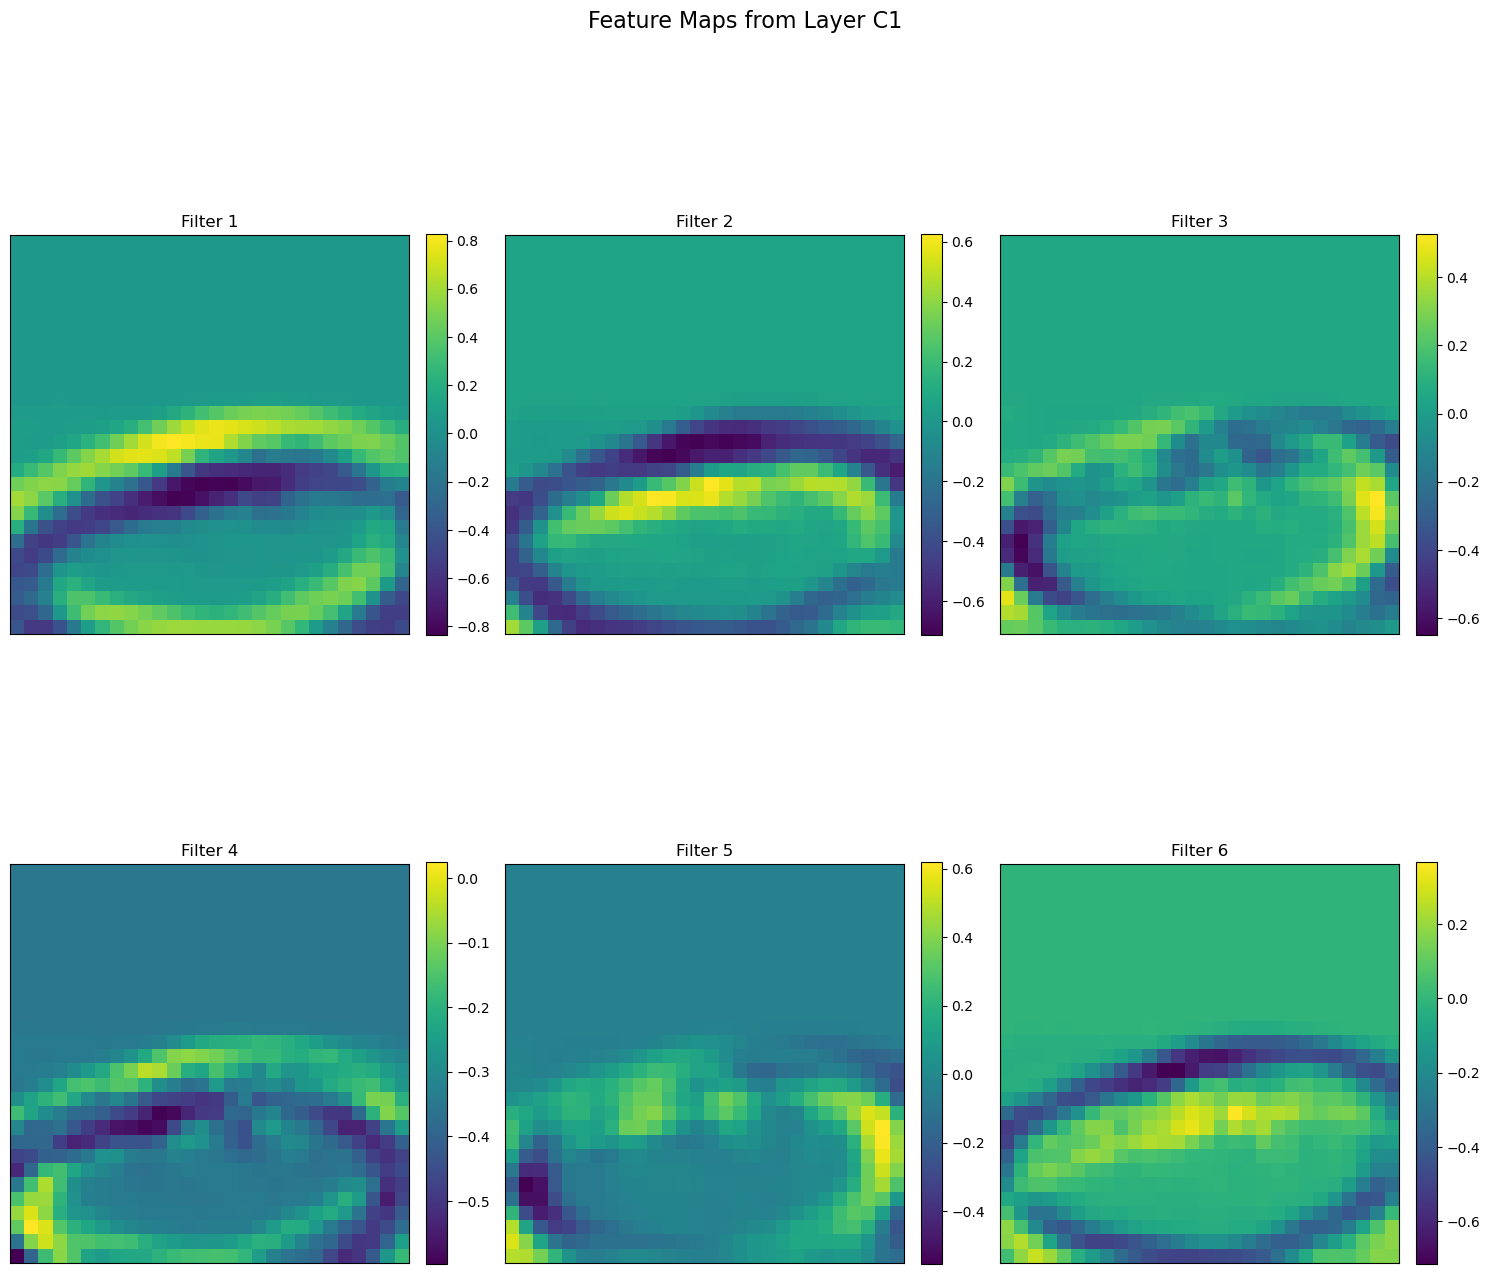

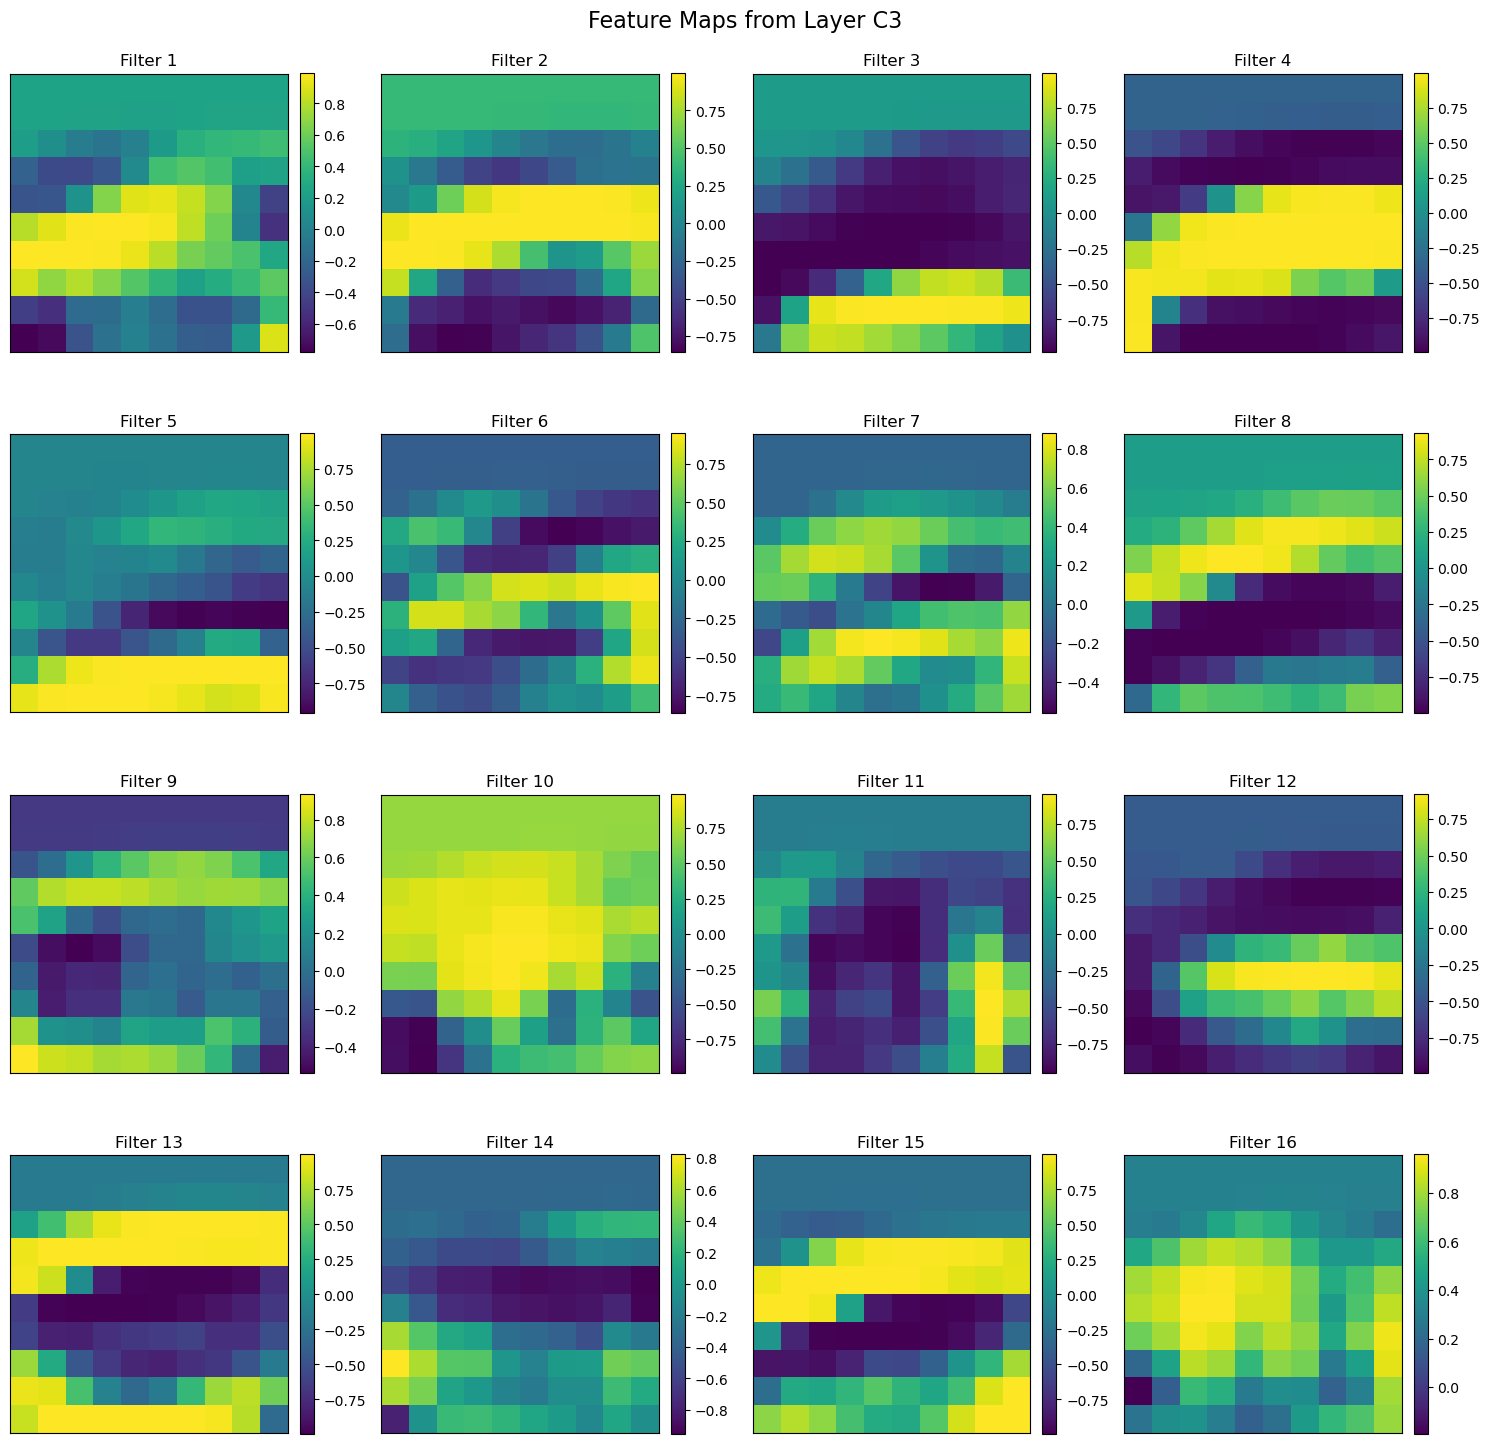


Model saved as 'lenet5_tifinagh_model.pth'

Training completed successfully!
Check the generated plots for training curves, confusion matrix, and feature maps.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import os
from PIL import Image
from collections import defaultdict

class LeNet5(nn.Module):
    """
    LeNet-5 CNN Architecture modified for Tifinagh character classification (33 classes)
    
    Architecture:
    Input (32x32x1) -> C1 (Conv 5x5, 6 filters) -> S2 (AvgPool 2x2) -> 
    C3 (Conv 5x5, 16 filters) -> S4 (AvgPool 2x2) -> C5 (FC 120) -> 
    F6 (FC 84) -> Output (FC 33)
    """
    
    def __init__(self, num_classes=33):
        super(LeNet5, self).__init__()
        
        # Convolutional layers
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        
        # Pooling layers (using average pooling as in original LeNet-5)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.c5 = nn.Linear(16 * 5 * 5, 120)  # 16 feature maps of 5x5 after pooling
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, num_classes)
        
        # Activation function
        self.activation = nn.Tanh()  # Original LeNet-5 used tanh
        
    def forward(self, x):
        # C1: Convolution + Activation
        x = self.activation(self.c1(x))  # 32x32x1 -> 28x28x6
        
        # S2: Average Pooling
        x = self.s2(x)  # 28x28x6 -> 14x14x6
        
        # C3: Convolution + Activation
        x = self.activation(self.c3(x))  # 14x14x6 -> 10x10x16
        
        # S4: Average Pooling
        x = self.s4(x)  # 10x10x16 -> 5x5x16
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 16*5*5)
        
        # C5: Fully Connected + Activation
        x = self.activation(self.c5(x))  # -> 120
        
        # F6: Fully Connected + Activation
        x = self.activation(self.f6(x))  # -> 84
        
        # Output: Final classification layer (no activation, will use CrossEntropy loss)
        x = self.output(x)  # -> 33
        
        return x
    
    def get_feature_maps(self, x):
        """Extract feature maps from different layers for visualization"""
        feature_maps = {}
        
        # C1 feature maps
        x = self.activation(self.c1(x))
        feature_maps['c1'] = x.clone()
        
        # S2
        x = self.s2(x)
        feature_maps['s2'] = x.clone()
        
        # C3 feature maps
        x = self.activation(self.c3(x))
        feature_maps['c3'] = x.clone()
        
        # S4
        x = self.s4(x)
        feature_maps['s4'] = x.clone()
        
        return feature_maps

class TifinaghDataset(Dataset):
    """Custom Dataset for Tifinagh characters from AMHCD_64 dataset"""
    
    def __init__(self, data_dir, transform=None, split='train', train_ratio=0.8):
        self.data_dir = data_dir
        self.transform = transform
        self.split = split
        self.train_ratio = train_ratio
        self.images = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        
        self._load_data()
    
    def _load_data(self):
        """Load images and labels from AMHCD_64 dataset structure"""
        # Get all class directories (ya, yab, yad, etc.)
        all_items = os.listdir(self.data_dir)
        classes = sorted([item for item in all_items if os.path.isdir(os.path.join(self.data_dir, item))])
        
        print(f"Found {len(classes)} classes: {classes}")
        
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        
        all_images = []
        all_labels = []
        
        for class_name in classes:
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_dir):
                class_images = []
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        class_images.append(img_path)
                
                # Sort for consistent train/val split
                class_images.sort()
                
                # Split into train/val for this class
                train_size = int(len(class_images) * self.train_ratio)
                
                if self.split == 'train':
                    selected_images = class_images[:train_size]
                else:  # validation
                    selected_images = class_images[train_size:]
                
                for img_path in selected_images:
                    all_images.append(img_path)
                    all_labels.append(self.class_to_idx[class_name])
                
                print(f"Class '{class_name}': {len(class_images)} total, "
                      f"{train_size} train, {len(class_images)-train_size} val")
        
        self.images = all_images
        self.labels = all_labels
        
        print(f"\n{self.split.capitalize()} set: {len(self.images)} images")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        
        try:
            # Load RGB image and convert to grayscale
            image = Image.open(img_path).convert('RGB')
            image = image.convert('L')  # RGB to grayscale
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
            
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image in case of error
            dummy_image = Image.new('L', (64, 64), 0)
            if self.transform:
                dummy_image = self.transform(dummy_image)
            return dummy_image, self.labels[idx]

class LeNet5Trainer:
    """Training and evaluation class for LeNet-5"""
    
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        
    def train_epoch(self, train_loader, optimizer, criterion):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            
            optimizer.zero_grad()
            output = self.model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            if batch_idx % 100 == 0:
                print(f'Batch {batch_idx}, Loss: {loss.item():.6f}')
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy
    
    def validate(self, val_loader, criterion):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = criterion(output, target)
                
                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
                
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy())
        
        avg_loss = total_loss / len(val_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy, all_preds, all_targets
    
    def train(self, train_loader, val_loader, optimizer, criterion, epochs=50):
        """Complete training loop"""
        print(f"Training on {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(epochs):
            print(f'\nEpoch {epoch+1}/{epochs}')
            print('-' * 50)
            
            # Training
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            
            # Validation
            val_loss, val_acc, _, _ = self.validate(val_loader, criterion)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            
        print('\nTraining completed!')
    
    def plot_training_curves(self):
        """Plot training and validation curves"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curves
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy curves
        ax2.plot(epochs, self.train_accuracies, 'b-', label='Training Accuracy')
        ax2.plot(epochs, self.val_accuracies, 'r-', label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, val_loader, class_names=None):
        """Plot confusion matrix"""
        _, _, all_preds, all_targets = self.validate(val_loader, nn.CrossEntropyLoss())
        
        # Create confusion matrix
        cm = confusion_matrix(all_targets, all_preds)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names if class_names else range(33),
                    yticklabels=class_names if class_names else range(33))
        plt.title('Confusion Matrix - Tifinagh Character Classification')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # Print classification report
        if class_names:
            print("\nClassification Report:")
            print(classification_report(all_targets, all_preds, target_names=class_names))
    
    def visualize_feature_maps(self, sample_image, layer_name='c1'):
        """Visualize feature maps from a specific layer"""
        self.model.eval()
        
        with torch.no_grad():
            sample_image = sample_image.unsqueeze(0).to(self.device)
            feature_maps = self.model.get_feature_maps(sample_image)
            
            if layer_name not in feature_maps:
                print(f"Layer {layer_name} not found. Available layers: {list(feature_maps.keys())}")
                return
            
            features = feature_maps[layer_name].squeeze(0).cpu()
            num_features = features.shape[0]
            
            # Calculate grid size
            cols = int(np.ceil(np.sqrt(num_features)))
            rows = int(np.ceil(num_features / cols))
            
            fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
            fig.suptitle(f'Feature Maps from Layer {layer_name.upper()}', fontsize=16)
            
            for i in range(rows * cols):
                row, col = i // cols, i % cols
                ax = axes[row, col] if rows > 1 else axes[col]
                
                if i < num_features:
                    feature_map = features[i].numpy()
                    im = ax.imshow(feature_map, cmap='viridis')
                    ax.set_title(f'Filter {i+1}')
                    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                else:
                    ax.axis('off')
                
                ax.set_xticks([])
                ax.set_yticks([])
            
            plt.tight_layout()
            plt.show()

def get_optimizers(model, learning_rate=0.001):
    """Get different optimizers for comparison"""
    optimizers = {
        'SGD': optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
        'Adam': optim.Adam(model.parameters(), lr=learning_rate),
        'RMSprop': optim.RMSprop(model.parameters(), lr=learning_rate),
        'AdaGrad': optim.Adagrad(model.parameters(), lr=learning_rate)
    }
    return optimizers

def get_data_transforms():
    """Get data transformations for training and validation"""
    train_transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize from 64x64 to 32x32 for LeNet-5
        transforms.RandomRotation(10),  # Data augmentation
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize from 64x64 to 32x32 for LeNet-5
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    return train_transform, val_transform

def create_data_loaders(data_dir, batch_size=32, train_ratio=0.8):
    """Create data loaders for training and validation from AMHCD_64 dataset"""
    train_transform, val_transform = get_data_transforms()
    
    # Create datasets with automatic train/val split
    train_dataset = TifinaghDataset(data_dir, transform=train_transform, split='train', train_ratio=train_ratio)
    val_dataset = TifinaghDataset(data_dir, transform=val_transform, split='val', train_ratio=train_ratio)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # num_workers=0 for Windows
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, val_loader, train_dataset.class_to_idx

def mathematical_formulas():
    """
    Mathematical formulas used in LeNet-5:
    
    1. Convolution Operation:
       Y[i,j] = Σ Σ X[i+m, j+n] * W[m,n] + b
       
    2. Average Pooling:
       Y[i,j] = (1/k²) * Σ Σ X[i*s+m, j*s+n]
       where k is kernel size, s is stride
       
    3. Tanh Activation:
       f(x) = tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))
       
    4. Cross-Entropy Loss:
       L = -Σ y_i * log(ŷ_i)
       where y_i is true label, ŷ_i is predicted probability
       
    5. SGD Update Rule:
       θ_{t+1} = θ_t - η * ∇L(θ_t)
       
    6. Adam Update Rule:
       m_t = β₁ * m_{t-1} + (1-β₁) * ∇L(θ_t)
       v_t = β₂ * v_{t-1} + (1-β₂) * (∇L(θ_t))²
       θ_{t+1} = θ_t - η * m_t / (√v_t + ε)
    """
    pass

def main():
    """Main training function for AMHCD_64 dataset"""
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Dataset path (update this to your actual path)
    data_dir = r"C:\Users\yousra\Desktop\University\lenet\dataset\AMHCD_64\AMHCD_64"
    # Alternative path format: "./dataset/AMHCD_64/AMHCD_64"
    
    # Hyperparameters
    batch_size = 32
    learning_rate = 0.001
    epochs = 10
    num_classes = 33  # Will be automatically detected from dataset
    
    # Check if dataset exists
    if not os.path.exists(data_dir):
        print(f"Dataset directory not found: {data_dir}")
        print("Please update the data_dir path in the main() function")
        return None
    
    try:
        # Data loading with automatic train/val split
        train_loader, val_loader, class_to_idx = create_data_loaders(
            data_dir, batch_size=batch_size, train_ratio=0.8
        )
        
        # Update num_classes based on actual dataset
        num_classes = len(class_to_idx)
        print(f"Detected {num_classes} classes in dataset")
        
        # Model initialization
        model = LeNet5(num_classes=num_classes)
        print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
        
        # Loss function
        criterion = nn.CrossEntropyLoss()
        
        # Training with Adam optimizer (you can try others)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        print(f"\n{'='*50}")
        print(f"Training LeNet-5 on Tifinagh AMHCD_64 Dataset")
        print(f"{'='*50}")
        
        # Create trainer
        trainer = LeNet5Trainer(model, device)
        
        # Train
        trainer.train(train_loader, val_loader, optimizer, criterion, epochs)
        
        # Plot results
        trainer.plot_training_curves()
        trainer.plot_confusion_matrix(val_loader, list(class_to_idx.keys()))
        
        # Visualize feature maps with sample
        sample_image, sample_label = next(iter(val_loader))
        trainer.visualize_feature_maps(sample_image[0], 'c1')
        trainer.visualize_feature_maps(sample_image[0], 'c3')
        
        # Save the trained model
        torch.save({
            'model_state_dict': model.state_dict(),
            'class_to_idx': class_to_idx,
            'num_classes': num_classes,
            'train_losses': trainer.train_losses,
            'val_losses': trainer.val_losses,
            'train_accuracies': trainer.train_accuracies,
            'val_accuracies': trainer.val_accuracies
        }, 'lenet5_tifinagh_model.pth')
        
        print(f"\nModel saved as 'lenet5_tifinagh_model.pth'")
        
        return model, trainer, class_to_idx
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Please check your dataset path and structure")
        return None

def test_model_architecture():
    """Test the model architecture with dummy data"""
    model = LeNet5(num_classes=33)
    
    # Create dummy input
    dummy_input = torch.randn(1, 1, 32, 32)
    
    # Forward pass
    with torch.no_grad():
        output = model(dummy_input)
        feature_maps = model.get_feature_maps(dummy_input)
    
    print("Model Architecture Test:")
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Feature maps available: {list(feature_maps.keys())}")
    
    for layer_name, feature_map in feature_maps.items():
        print(f"{layer_name.upper()} shape: {feature_map.shape}")
    
    # Print model summary
    print(f"\nModel Summary:")
    print(model)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

if __name__ == "__main__":
    # Test the architecture first
    print("Testing model architecture...")
    test_model_architecture()
    
    print("\n" + "="*60)
    print("Starting training on AMHCD_64 dataset...")
    print("="*60)
    
    # Run main training with your dataset
    result = main()
    
    if result is None:
        print("\nTraining failed. Please check your dataset path.")
        print("Expected structure:")
        print("dataset/AMHCD_64/AMHCD_64/")
        print("├── ya/")
        print("├── yab/")
        print("├── yad/")
        print("└── ... (other Tifinagh classes)")
    else:
        print("\nTraining completed successfully!")
        print("Check the generated plots for training curves, confusion matrix, and feature maps.")